In [48]:
import os
import cv2
import sys
import yaml
import time
import argparse
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
# import torch.nn as nn
from scipy.io import loadmat
import matplotlib.pyplot as plt
from distutils.version import LooseVersion

##################### model stuff #####################
# System libs
import csv, torch, scipy.io, PIL.Image, torchvision.transforms
# Our libs
from mit_semseg.config import cfg
from mit_semseg.utils import colorEncode
from mit_semseg.dataset import ValDataset
from mit_semseg.lib.utils import as_numpy
from mit_semseg.models import ModelBuilder, SegmentationModule
from mit_semseg.lib.nn import user_scattered_collate, async_copy_to
from mit_semseg.utils import AverageMeter, colorEncode, accuracy, intersectionAndUnion, setup_logger


sys.path.insert(1, '/home/zyang/Documents/Noisey-image')
from noise_video_gen import *

In [2]:
# pass in mode config(yaml file)
# return a dict for the file 
# return decoder and encoder weights path
def parse_model_config(path):
    with open(path) as file:
        data = yaml.load(file, Loader=yaml.FullLoader)
    
    encoder_path = None
    decoder_path = None

    for p in os.listdir(data['DIR']):
        if "encoder" in p.lower():
            encoder_path = "{}/{}".format(data['DIR'], p)
            continue
        if "decoder" in p.lower():
            decoder_path = "{}/{}".format(data['DIR'], p)
            continue

    if encoder_path==None or decoder_path==None:
        raise("model weights not found")
        
    return data, encoder_path, decoder_path

def visualize_result(img, pred, index=None):
    # filter prediction class if requested
    if index is not None:
        pred = pred.copy()
        pred[pred != index] = -1
        print(f'{names[index+1]}:')

    # colorize prediction
    pred_color = colorEncode(pred, colors).astype(numpy.uint8)

    # aggregate images and save
    im_vis = numpy.concatenate((img, pred_color), axis=1)
    #if show==True:
        #display(PIL.Image.fromarray(im_vis))
    #else:
    return pred_color, im_vis

def process_img(path=None, frame=None):
    # Load and normalize one image as a singleton tensor batch
    pil_to_tensor = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], # These are RGB mean+std values
            std=[0.229, 0.224, 0.225])  # across a large photo dataset.
    ])
    # pil_image = PIL.Image.open('../ADE_val_00001519.jpg').convert('RGB')
    if path!=None:
        pil_image = PIL.Image.open(path).convert('RGB')
    else:
        pil_image = PIL.Image.fromarray(frame)

    # img_original = numpy.array(pil_image)
    img_original = np.array(pil_image)
    img_data = pil_to_tensor(pil_image)
    singleton_batch = {'img_data': img_data[None].cuda()}
    output_size = img_data.shape[1:]
    return img_original, singleton_batch, output_size

def predict_img(segmentation_module, singleton_batch, output_size):
    # Run the segmentation at the highest resolution.
    with torch.no_grad():
        scores = segmentation_module(singleton_batch, segSize=output_size)

    # Get the predicted scores for each pixel
    _, pred = torch.max(scores, dim=1)
    pred = pred.cpu()[0].numpy()
    return pred


def get_color_palette(pred, bar_height):

    pred = np.int32(pred)
    pixs = pred.size

    top_left_y = 0
    bottom_right_y = 30
    uniques, counts = np.unique(pred, return_counts=True)

    # Create a black image
    # bar_height = im_vis.shape[0]
    img = np.zeros((bar_height,250,3), np.uint8)

    for idx in np.argsort(counts)[::-1]:
        color_index = uniques[idx]
        name = names[color_index + 1]
        ratio = counts[idx] / pixs * 100
        if ratio > 0.1:
            print("{}  {}: {:.2f}% {}".format(color_index+1, name, ratio, colors[color_index]))
            img = cv2.rectangle(img, (0,top_left_y), (250,bottom_right_y), 
                       (int(colors[color_index][0]),int(colors[color_index][1]),int(colors[color_index][2])), -1)
            img = cv2.putText(img, "{}: {:.3f}%".format(name, ratio), (0,top_left_y+20), 5, 1, (255,255,255), 2, cv2.LINE_AA)
            top_left_y+=30
            bottom_right_y+=30
            
    return img


def transparent_overlays(image, annotation, alpha=0.5):
    img1 = image.copy()
    img2 = annotation.copy()

    # I want to put logo on top-left corner, So I create a ROI
    rows,cols,channels = img2.shape
    roi = img1[0:rows, 0:cols ]

    # Now create a mask of logo and create its inverse mask also
    img2gray = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
    ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
    mask_inv = cv2.bitwise_not(mask)

    # Now black-out the area of logo in ROI
    # img1_bg = cv2.bitwise_and(roi,roi,mask = mask_inv)

    # Take only region of logo from logo image.
    img2_fg = cv2.bitwise_and(img2,img2,mask = mask)

    # Put logo in ROI and modify the main image
    # dst = cv2.add(img1_bg, img2_fg)
    dst = cv2.addWeighted(image.copy(), 1-alpha, img2_fg, alpha, 0)
    img1[0:rows, 0:cols ] = dst
    return dst


def evaluate(segmentation_module, loader, cfg, gpu):
    acc_meter = AverageMeter()
    intersection_meter = AverageMeter()
    union_meter = AverageMeter()
    time_meter = AverageMeter()

    segmentation_module.eval()

    pbar = tqdm(total=len(loader), leave=False)
    for batch_data in loader:
        # process data
        batch_data = batch_data[0]
        seg_label = as_numpy(batch_data['seg_label'][0])
        img_resized_list = batch_data['img_data']

        torch.cuda.synchronize()
        tic = time.perf_counter()
        with torch.no_grad():
            segSize = (seg_label.shape[0], seg_label.shape[1])
            scores = torch.zeros(1, cfg.DATASET.num_class, segSize[0], segSize[1])
            scores = async_copy_to(scores, gpu)

            for img in img_resized_list:
                feed_dict = batch_data.copy()
                feed_dict['img_data'] = img
                del feed_dict['img_ori']
                del feed_dict['info']
                feed_dict = async_copy_to(feed_dict, gpu)

                # forward pass
                scores_tmp = segmentation_module(feed_dict, segSize=segSize)
                scores = scores + scores_tmp / len(cfg.DATASET.imgSizes)

            _, pred = torch.max(scores, dim=1)
            pred = as_numpy(pred.squeeze(0).cpu())

        torch.cuda.synchronize()
        time_meter.update(time.perf_counter() - tic)

        # calculate accuracy
        acc, pix = accuracy(pred, seg_label)
        intersection, union = intersectionAndUnion(pred, seg_label, cfg.DATASET.num_class)
        acc_meter.update(acc, pix)
        intersection_meter.update(intersection)
        union_meter.update(union)

        # visualization
        if cfg.VAL.visualize:
            visualize_result(
                (batch_data['img_ori'], seg_label, batch_data['info']),
                pred,
                os.path.join(cfg.DIR, 'result')
            )

        pbar.update(1)

    # summary
    iou = intersection_meter.sum / (union_meter.sum + 1e-10)
    #for i, _iou in enumerate(iou):
        #print('class [{}], IoU: {:.4f}'.format(i, _iou))

    #print('[Eval Summary]:')
    #print('Mean IoU: {:.4f}, Accuracy: {:.2f}%, Inference Time: {:.4f}s'
    #      .format(iou.mean(), acc_meter.average()*100, time_meter.average()))
    
    return pred, acc_meter.average()*100


# create a tmp_obgt for 1 img
def create_tmp_obgt(img_path, anno_path, width, height, tmp_path="tmp_results/tmp_eval.odgt"):
    eval_img = "{\"fpath_img\": " + "\"{}\", ".format(img_path) + "\"fpath_segm\": " + "\"{}\", ".format(anno_path) + \
                "\"width\": " + str(width) + ", \"height\": " + str(height) + "}"
    f = open(tmp_path, "w")
    f.write("{}".format(eval_img))
    f.close()
    
    
def setup_oneImg_loader(img_path, anno_path, tmp_path="tmp_results/tmp_eval.odgt", update=0):
    img = PIL.Image.open(img_path).convert('RGB')
    anno_rgb = PIL.Image.open(anno_path).convert('RGB')
    anno = PIL.Image.open(anno_path)
    anno = np.array(anno)
    anno[np.where(anno!=0)]-=1

    width = img.size[0]
    height = img.size[1]
    # im_vis = numpy.concatenate((img, anno_rgb), axis=1)
    # display(PIL.Image.fromarray(im_vis))
    if update==0:
        create_tmp_obgt(img_path, anno_path, width, height, tmp_path=tmp_path)
    
    # Dataset and Loader
    dataset_val = ValDataset("", tmp_path, cfg.DATASET)
    loader_val = torch.utils.data.DataLoader(
        dataset_val,
        batch_size=1,
        shuffle=False,
        collate_fn=user_scattered_collate,
        num_workers=1,
        drop_last=True)
    
    return loader_val

In [16]:
# colors
colors = scipy.io.loadmat('data/color150.mat')['colors']
names = {}
with open('data/object150_info.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        names[int(row[0])] = row[5].split(";")[0]

# parse cfg
cfg.merge_from_file("config/ade20k-resnet50dilated-ppm_deepsup.yaml")
# cfg.merge_from_list(opts)

# Network Builders
print("parsing {}".format("config/ade20k-resnet50dilated-ppm_deepsup.yaml"))
model_config, encoder_path, decoder_path = parse_model_config("config/ade20k-resnet50dilated-ppm_deepsup.yaml")
net_encoder = ModelBuilder.build_encoder(
    arch = model_config["MODEL"]['arch_encoder'],
    fc_dim = model_config['MODEL']['fc_dim'],
    weights = encoder_path)
net_decoder = ModelBuilder.build_decoder(
    arch = model_config["MODEL"]['arch_decoder'],
    fc_dim = model_config['MODEL']['fc_dim'],
    num_class = model_config['DATASET']['num_class'],
    weights = decoder_path,
    use_softmax=True)

crit = torch.nn.NLLLoss(ignore_index=-1)
segmentation_module = SegmentationModule(net_encoder, net_decoder, crit)
segmentation_module.eval()
segmentation_module.cuda()

# predict on 1 img
print("\nEvaluation on\nImages: {}\nAnnotation: {}\n".format(img_path, img_path))
#img_path = args.img
#anno_path = args.anno

parsing config/ade20k-resnet50dilated-ppm_deepsup.yaml
Loading weights for net_encoder
Loading weights for net_decoder

Evaluation on
Images: /home/zyang/Documents/fork_sseg_mit/notebooks/data/ADEChallengeData2016/images/training/ADE_train_00000001.jpg
Annotation: /home/zyang/Documents/fork_sseg_mit/notebooks/data/ADEChallengeData2016/images/training/ADE_train_00000001.jpg



In [3]:
img_path = "/home/zyang/Documents/fork_sseg_mit/notebooks/data/ADEChallengeData2016/images/training/ADE_train_00000001.jpg"
anno_path = "/home/zyang/Documents/fork_sseg_mit/notebooks/data/ADEChallengeData2016/annotations/training/ADE_train_00000001.png"

tmp_img_path = '../tmp_results/tmp.jpg'

In [35]:
def get_anno(anno_path):
    anno = PIL.Image.open(anno_path)
    anno = np.array(anno)
    anno[np.where(anno!=0)]-=1
    return anno

def get_eval_res(pred, anno):
    acc_meter = AverageMeter()
    intersection_meter = AverageMeter()
    union_meter = AverageMeter()

    acc, pix = accuracy(pred, anno)
    intersection, union = intersectionAndUnion(pred, anno, 150)
    acc_meter.update(acc, pix)
    intersection_meter.update(intersection)
    union_meter.update(union)
    
    class_ious = {}
    iou = intersection_meter.sum / (union_meter.sum + 1e-10)
    for i, _iou in enumerate(iou):
        #print('class [{}], IoU: {:.4f}'.format(i, _iou))
        class_ious[i] = _iou
    #print('[Eval Summary]:')
    #print('Mean IoU: {:.4f}, Accuracy: {:.2f}%'.format(iou.mean(), acc_meter.average()*100))
    return iou.mean(), acc_meter.average(), class_ious

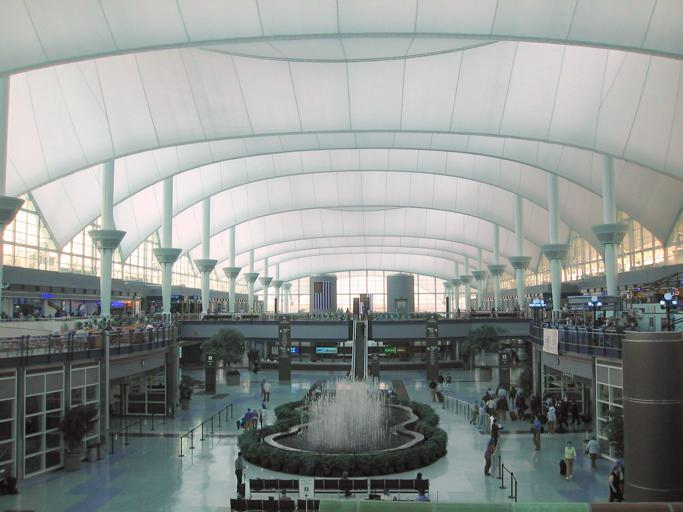

In [102]:
org_img = cv2.imread(img_path)
noise_img = saltAndPapper_noise(org_img, 0.0)
display(PIL.Image.fromarray(noise_img))

In [103]:
# img_original, singleton_batch, output_size = process_img(path=img_path)
img_original, singleton_batch, output_size = process_img(frame=noise_img)
pred = predict_img(segmentation_module, singleton_batch, output_size)

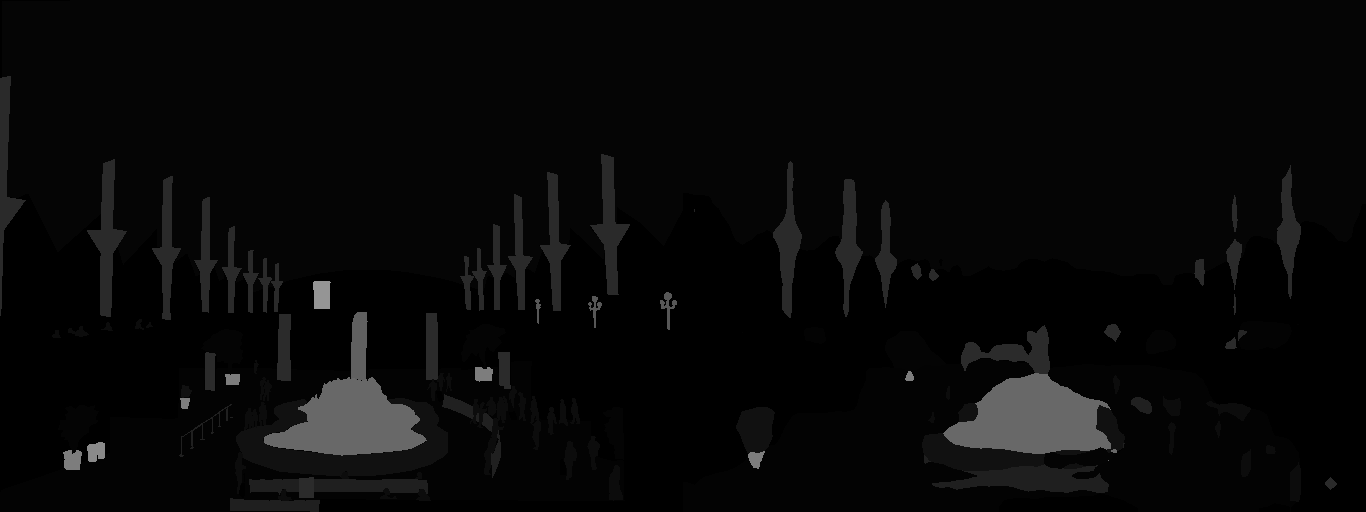

In [104]:
display(PIL.Image.fromarray(np.concatenate((anno, pred), axis=1).astype(np.uint8)))

In [105]:
acc_meter = AverageMeter()
intersection_meter = AverageMeter()
union_meter = AverageMeter()
time_meter = AverageMeter()

acc, pix = accuracy(pred, anno)
intersection, union = intersectionAndUnion(pred, anno, 150)
acc_meter.update(acc, pix)
intersection_meter.update(intersection)
union_meter.update(union)

In [106]:
class_ious = {}
iou = intersection_meter.sum / (union_meter.sum + 1e-10)
for i, _iou in enumerate(iou):
    #print('class [{}], IoU: {:.4f}'.format(i, _iou))
    class_ious[i] = _iou

print('[Eval Summary]:')
print('Mean IoU: {:.4f}, Accuracy: {:.2f}%'.format(iou.mean(), acc_meter.average()*100))

[Eval Summary]:
Mean IoU: 0.0357, Accuracy: 88.14%


In [107]:
acc_meter.average()

0.8814227214494873

In [108]:
iou.mean()

0.03573501103922743

In [109]:
class_ious

{0: 0.7978678910338025,
 1: 0.0,
 2: 0.0,
 3: 0.6996093607389275,
 4: 0.2811973807296486,
 5: 0.9494163424124509,
 6: 0.0,
 7: 0.0,
 8: 0.0,
 9: 0.0,
 10: 0.0,
 11: 0.0,
 12: 0.16726112258306425,
 13: 0.0,
 14: 0.0,
 15: 0.0,
 16: 0.0,
 17: 0.3994619253713838,
 18: 0.0,
 19: 0.0,
 20: 0.0,
 21: 0.0,
 22: 0.0,
 23: 0.0,
 24: 0.0,
 25: 0.0,
 26: 0.0,
 27: 0.0,
 28: 0.0,
 29: 0.0,
 30: 0.0,
 31: 0.33992446123083003,
 32: 0.21176470588233218,
 33: 0.0,
 34: 0.0,
 35: 0.0,
 36: 0.0,
 37: 0.0,
 38: 0.0,
 39: 0.0,
 40: 0.0,
 41: 0.0,
 42: 0.3501338090990165,
 43: 0.08864767073722098,
 44: 0.0,
 45: 0.0,
 46: 0.0,
 47: 0.0,
 48: 0.0,
 49: 0.0,
 50: 0.0,
 51: 0.0,
 52: 0.0,
 53: 0.0,
 54: 0.0,
 55: 0.0,
 56: 0.0,
 57: 0.0,
 58: 0.0,
 59: 0.0,
 60: 0.0,
 61: 0.0,
 62: 0.0,
 63: 0.0,
 64: 0.0,
 65: 0.0,
 66: 0.0,
 67: 0.0,
 68: 0.0,
 69: 0.0,
 70: 0.0,
 71: 0.0,
 72: 0.0,
 73: 0.0,
 74: 0.0,
 75: 0.0,
 76: 0.0,
 77: 0.0,
 78: 0.0,
 79: 0.0,
 80: 0.0,
 81: 0.0,
 82: 0.0,
 83: 0.0,
 84: 0.0,
 85: 0

In [110]:
anno = get_anno(anno_path)
mean_iou, acc, class_ious = get_eval_res(pred, anno)

In [111]:
mean_iou

0.03573501103922743

In [112]:
acc

0.8814227214494873

In [113]:
a = class_ious.copy()

In [114]:
anno_path

'/home/zyang/Documents/fork_sseg_mit/notebooks/data/ADEChallengeData2016/annotations/training/ADE_train_00000001.png'

In [115]:
len(np.unique(anno))

16

In [116]:
len(np.unique(pred))

14

In [117]:
a

{0: 0.7978678910338025,
 1: 0.0,
 2: 0.0,
 3: 0.6996093607389275,
 4: 0.2811973807296486,
 5: 0.9494163424124509,
 6: 0.0,
 7: 0.0,
 8: 0.0,
 9: 0.0,
 10: 0.0,
 11: 0.0,
 12: 0.16726112258306425,
 13: 0.0,
 14: 0.0,
 15: 0.0,
 16: 0.0,
 17: 0.3994619253713838,
 18: 0.0,
 19: 0.0,
 20: 0.0,
 21: 0.0,
 22: 0.0,
 23: 0.0,
 24: 0.0,
 25: 0.0,
 26: 0.0,
 27: 0.0,
 28: 0.0,
 29: 0.0,
 30: 0.0,
 31: 0.33992446123083003,
 32: 0.21176470588233218,
 33: 0.0,
 34: 0.0,
 35: 0.0,
 36: 0.0,
 37: 0.0,
 38: 0.0,
 39: 0.0,
 40: 0.0,
 41: 0.0,
 42: 0.3501338090990165,
 43: 0.08864767073722098,
 44: 0.0,
 45: 0.0,
 46: 0.0,
 47: 0.0,
 48: 0.0,
 49: 0.0,
 50: 0.0,
 51: 0.0,
 52: 0.0,
 53: 0.0,
 54: 0.0,
 55: 0.0,
 56: 0.0,
 57: 0.0,
 58: 0.0,
 59: 0.0,
 60: 0.0,
 61: 0.0,
 62: 0.0,
 63: 0.0,
 64: 0.0,
 65: 0.0,
 66: 0.0,
 67: 0.0,
 68: 0.0,
 69: 0.0,
 70: 0.0,
 71: 0.0,
 72: 0.0,
 73: 0.0,
 74: 0.0,
 75: 0.0,
 76: 0.0,
 77: 0.0,
 78: 0.0,
 79: 0.0,
 80: 0.0,
 81: 0.0,
 82: 0.0,
 83: 0.0,
 84: 0.0,
 85: 0

In [118]:
img_path

'/home/zyang/Documents/fork_sseg_mit/notebooks/data/ADEChallengeData2016/images/training/ADE_train_00000001.jpg'

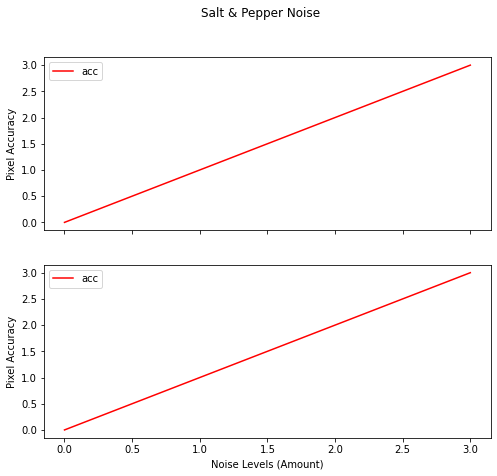

In [151]:
fig, axs = plt.subplots(2, figsize=(8,7))
fig.suptitle('Salt & Pepper Noise')

x = [0,1,2,3]

axs[0].plot(x,x, label="acc", color='r')
# axs[0].xlabel('Noise Levels (Amount)')
axs[0].set_ylabel('Pixel Accuracy')
#axs[0].set_title('Salt & Pepper Noise')

axs[1].plot(x,x, label="acc", color='r')
axs[1].set_xlabel('Noise Levels (Amount)')
axs[1].set_ylabel('Pixel Accuracy')
#axs[1].set_title('Salt & Pepper Noise')


for ax in fig.get_axes():
    ax.label_outer()
    
#axs[0].tight_layout()
axs[0].legend()
axs[1].legend()

# plt.tight_layout()
fig.show()

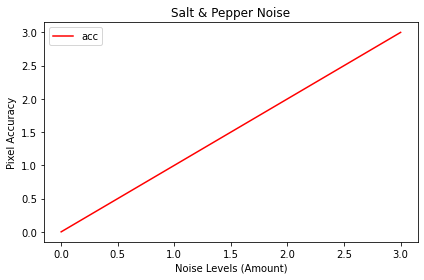

In [120]:
x = [0,1,2,3]

plt.plot(x,x, label="acc", color='r')
plt.xlabel('Noise Levels (Amount)')
plt.ylabel('Pixel Accuracy')
plt.title('Salt & Pepper Noise')
plt.tight_layout()
plt.legend()
plt.show()

In [123]:
# class_ious

In [139]:
colors = scipy.io.loadmat('data/color150.mat')['colors']
names = {}
with open('data/object150_info.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        names[int(row[0])] = row[5].split(";")[0]

In [207]:
# return class_ious!=0
# only count for classes that appeared in anno
# it is able to update the pass in dict
def process_class_ious(class_ious, anno, name_iou=None):
    gt_classes = np.unique(anno)
    tmp_dict = {k: v for k, v in sorted(class_ious.items(), key=lambda item: item[1], reverse=True) if v!=0}
    
    if name_iou==None:
        name_iou = {}
    for k, v in tmp_dict.items():
        if k in gt_classes:
            try:
                name_iou[names[k+1]].append(v)
            except:
                name_iou[names[k+1]] = [v]
    return name_iou

In [209]:
name_iou = process_class_ious(class_ious, anno, name_iou)
name_iou

{'ceiling': [0.9494163424124509,
  0.9494163424124509,
  0.9494163424124509,
  0.9494163424124509],
 'fountain': [0.8055495103373144,
  0.8055495103373144,
  0.8055495103373144,
  0.8055495103373144],
 'wall': [0.7978678910338025,
  0.7978678910338025,
  0.7978678910338025,
  0.7978678910338025],
 'floor': [0.6996093607389275,
  0.6996093607389275,
  0.6996093607389275,
  0.6996093607389275],
 'plant': [0.3994619253713838,
  0.3994619253713838,
  0.3994619253713838,
  0.3994619253713838],
 'column': [0.3501338090990165,
  0.3501338090990165,
  0.3501338090990165,
  0.3501338090990165],
 'seat': [0.33992446123083003,
  0.33992446123083003,
  0.33992446123083003,
  0.33992446123083003],
 'tree': [0.2811973807296486,
  0.2811973807296486,
  0.2811973807296486,
  0.2811973807296486],
 'pot': [0.26941747572812264,
  0.26941747572812264,
  0.26941747572812264,
  0.26941747572812264],
 'fence': [0.21176470588233218,
  0.21176470588233218,
  0.21176470588233218,
  0.21176470588233218],
 'perso

In [214]:
def sub_line_plt(ax, x, y, title=None, label=None, color='r', yl=None, xl=None, clear=True):
    if clear:
        ax.clear()
    ax.set_title(title)
    ax.plot(x, y, label=label, color=color)
    ax.set_ylabel(yl)
    ax.set_xlabel(xl)

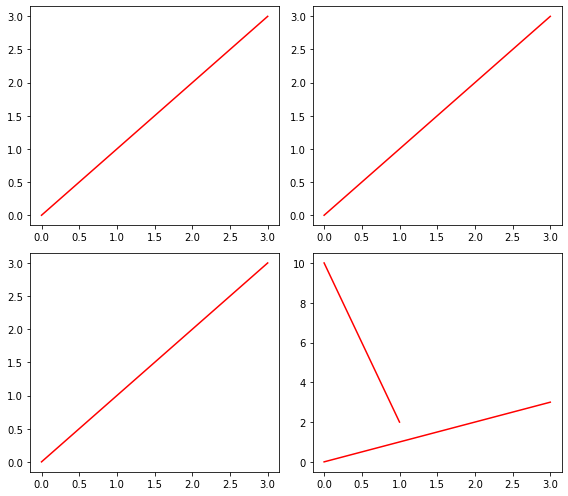

In [215]:
fig, axs = plt.subplots(2,2, figsize=(8,7))
#fig.suptitle('Salt & Pepper Noise')

x = [0,1,2,3]

sub_line_plt(axs[0][0], x, x)
sub_line_plt(axs[0][1], x, x)
sub_line_plt(axs[1][0], x, x)
sub_line_plt(axs[1][1], x, x)
sub_line_plt(axs[1][1], x[:-2], [10,2], clear=False)

# axs[0].xlabel('Noise Levels (Amount)')
#axs[0].set_title('Salt & Pepper Noise')

#axs[1].plot(x,x, label="acc", color='r')
#axs[1].set_xlabel('Noise Levels (Amount)')


#for ax in fig.get_axes():
#    ax.label_outer()
    
#axs[0].tight_layout()
#axs[0].legend()
#axs[1].legend()

fig.tight_layout()
fig.show()

In [187]:
#axs[0][0].clear()

In [188]:
sub_line_plt(axs[1][1], x, [10,2,2,10])
fig.show()

In [221]:
gt_classes = np.unique(anno)
gt_classes

array([  0,   3,   4,   5,  12,  17,  31,  32,  42,  43,  87,  96, 104,
       125, 138, 149], dtype=uint8)

In [222]:
np.unique(pred)

array([  0,   3,   4,   5,  12,  17,  31,  32,  36,  38,  42,  43, 104,
       125])

In [220]:
set(gt_classes) & set(pd)

{0, 3, 4, 5, 12, 17, 31, 32, 42, 43, 104, 125}

In [223]:
a = [0,1,2,3,4,5]
b = [0,1,2,3,4,5,6,7,8]

In [224]:
b[:len(a)]

[0, 1, 2, 3, 4, 5]

In [229]:
a = "13,12"
int(a.split(',')[0])
int(a.split(',')[1])

12

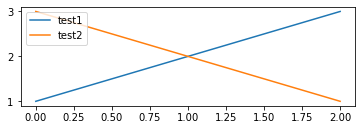

In [230]:
x = [1,2,3]
plt.subplot(211)
plt.plot(x, label="test1")
plt.plot([3,2,1], label="test2")
plt.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
plt.show()

In [234]:
import multiprocessing  # the module we will be using for multiprocessing

def work(number):
    print("Unit of work number %d" % number)  # simply print the worker's number
    
if __name__ == "__main__":  # Allows for the safe importing of the main module
    print("There are %d CPUs on this machine" % multiprocessing.cpu_count())
    
    number_processes = 4
    pool = multiprocessing.Pool(number_processes)
    total_tasks = 16
    tasks = range(total_tasks)
    results = pool.map_async(work, tasks)
    pool.close()
    pool.join()

There are 12 CPUs on this machine
Unit of work number 0Unit of work number 2Unit of work number 1


Unit of work number 4Unit of work number 5Unit of work number 6Unit of work number 3


Unit of work number 7
Unit of work number 8
Unit of work number 9Unit of work number 10


Unit of work number 12Unit of work number 11Unit of work number 13Unit of work number 14



Unit of work number 15


In [ ]:
saltAndPapper_noise()